In [1]:
import json
import os
import re
import glob
import time
import numpy as np
import pandas as pd
from scipy.stats import sem
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import cortex as cx
import seaborn as sns
from scipy.stats import ttest_rel, ttest_ind
from sklearn.linear_model import LinearRegression
from prf_expect.utils import io
from prf_expect.utils.fit import PRFModel, Parameters, fwhmax_fwatmin
from prf_expect.utils.beh import calculate_visual_angle
from prf_expect.utils.viz import desaturate_palette, sample_cmap, cm_to_inch
from matplotlib.colors import LightSource
from scipy.stats import t
from matplotlib import rc
from matplotlib import font_manager

In [2]:
glm_analysis_type = "TRMI-type3"
save_figs = True
comb_ROIs = False

In [3]:
cwd = os.getcwd()
analysis_result_dir = Path(cwd).parent / "data"

In [4]:
font_dirs = [Path(cwd).parent.parent / "arial"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

rc('pdf', fonttype=42, use14corefonts=False)
rc('axes', linewidth=0.5)
rc('font',**{'family':'Arial'})
rc('text', usetex=False)
rc('xtick', labelsize=6)
rc('ytick', labelsize=6)
rc('axes', labelsize=7)
rc('legend', fontsize=6)

plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['ytick.minor.size'] = 1

# set up figure parameters
markeredgecolor = ".4"
bar_linewidth = 0.5
bar_alpha = 0.7
xticks_rotation = 45
marker = "s"
marker_edge_width = 0.5
markersize = 3/2.54
errorbar_linewidth = 0.5
errorbar_capsize = 2/2.54
errorbar_capthick = 0.5

In [5]:
settings = io.load_settings()

Loading settings from /Users/dionysus/Library/CloudStorage/OneDrive-Personal/Workbench/pRF_expect_pub/pRF_expect_analysis/prf_expect/settings.yml


In [6]:
subjects = settings["general"]["subject_list"]
dummy_scans = settings["mri"]["dummy_scans"]
space = settings["mri"]["space"]
project_dir = os.path.join(settings["general"]["data_dir"], "data")
runs = ["01", "02", "03"]
half_vis_angle = calculate_visual_angle(settings["monitor"]["screen_size_cm"][1], 
                                        settings["monitor"]["screen_distance_cm"]) / 2
r2_thre = 0.1
print(f"Half visual angle: {half_vis_angle}")

Half visual angle: 5.723617240476087


In [7]:
# set half_vis_angle to a smaller value to avoid edge effects
half_vis_angle = 5

In [8]:
ROIs_list_long = ('V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'LO1', 'LO2', 'VO1', 
        'VO2', 'hMT', 'MST', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5')
ROIs_list_short = ["V1", "V2", "V3", "V3AB", "hV4", "LO", "TO", "VO", "IPS"]
roi_verts = cx.get_roi_verts('fsaverage', ROIs_list_long)
V1 = roi_verts['V1']
vis_verts = np.array([], dtype=int)
for roi in roi_verts:
    vis_verts = np.concatenate((vis_verts, roi_verts[roi]))

In [9]:
# norm subject number to [0,1]
def norm_subjects(subj):
    subj = np.array(subj)
    return (subj - min(subj)) / (max(subj) - min(subj))

norm_subID = norm_subjects(list(range(0, len(subjects) + 1)))

In [10]:
combined_roi_verts = {}
combined_roi_verts["V1"] = roi_verts["V1"]
combined_roi_verts["V2"] = roi_verts["V2"]
combined_roi_verts["V3"] = roi_verts["V3"]
combined_roi_verts["V3AB"] = np.concatenate((roi_verts["V3A"], roi_verts["V3B"]))
combined_roi_verts["hV4"] = roi_verts["V4"]
combined_roi_verts["LO"] = np.concatenate((roi_verts["LO1"], roi_verts["LO2"]))
combined_roi_verts["TO"] = np.concatenate((roi_verts["hMT"], roi_verts["MST"]))
combined_roi_verts["VO"] = np.concatenate((roi_verts["VO1"], roi_verts["VO2"]))
combined_roi_verts["IPS"] = np.concatenate((roi_verts["IPS0"], 
                                            roi_verts["IPS1"], 
                                            roi_verts["IPS2"], 
                                            roi_verts["IPS3"], 
                                            roi_verts["IPS4"], 
                                            roi_verts["IPS5"]))
if comb_ROIs == True:
    rois = combined_roi_verts
else:
    rois = roi_verts

ROIs_list = list(rois.keys())

In [11]:
# Define paths and data exp parameters
data_dir = Path(settings['general']['data_dir'], "data")
tasks = settings["design"]["tasks"]
space = settings["mri"]["space"]

## Load pRF results

In [12]:
# calculate IQR
def iqr(data):
    return np.nanpercentile(data, 75) - np.nanpercentile(data, 25)

In [13]:
rsq_list = []
rsq_list_2 = []
b_list = []
d_list = []
x_list = []
y_list = []
pa_list = []
ecc_list = []
prf_size_list = []
prf_hwhm_list = []
size_ratio_list = []
TRMI_list = []
viol_beta_spardm_list = []
viol_beta_omitdm_list = []
rsq_nanmask_list = []
viol_tstat_list = []

for subject in subjects:
    tsv_name = Path.joinpath(data_dir, 
                            "derivatives", 
                            "prf_data", 
                            subject, 
                            "ses-1", 
                            "prf_fits", 
                            "prf_params", 
                            f"{subject}_ses-1_final-fit_space-{space}_model-norm_stage-iter_desc-prf_params.tsv")
    TRMI_npy_name = Path.joinpath(data_dir,
                            "derivatives",
                            "prf_data",
                            subject,
                            "ses-1",
                            glm_analysis_type,
                            f"{subject}_ses-1_space-{space}_surprise-TRMI.npy")
    viol_rsq = Path.joinpath(data_dir,
                            "derivatives",
                            "prf_data",
                            subject,
                            "ses-1",
                            glm_analysis_type,
                            f"{subject}_ses-1_space-{space}_surprise-viol_rsq.npy")
    viol_beta_spardm = Path.joinpath(data_dir,
                            "derivatives",
                            "prf_data",
                            subject,
                            "ses-1",
                            glm_analysis_type,
                            f"{subject}_ses-1_space-{space}_surprise-viol_beta_sparsedm.npy")
    viol_beta_omitdm = Path.joinpath(data_dir,
                            "derivatives",
                            "prf_data",
                            subject,
                            "ses-1",
                            glm_analysis_type,
                            f"{subject}_ses-1_space-{space}_surprise-viol_beta_omitdm.npy")
    viol_tstat_npy_name = Path.joinpath(data_dir,
                            "derivatives",
                            "prf_data",
                            subject,
                            "ses-1",
                            glm_analysis_type,
                            f"{subject}_ses-1_space-{space}_surprise-viol_t_contrast.npy")
    data = pd.read_csv( 
            tsv_name,
            sep="\t",
            header=0,
        )
    mask = data["r2"] >= r2_thre
    mask_broadcasted = np.tile(mask, (data.shape[1], 1)).T
    params = data.where(mask_broadcasted)
    params_np = params.to_numpy()
    b = params["B"]
    d = params["D"]
    verts_nr = params["r2"].shape[0]
    
    sub_vis_rsq = np.zeros(verts_nr)
    sub_vis_rsq[:] = np.nan
    sub_vis_rsq = params["r2"]

    sub_vis_x = np.zeros(verts_nr)
    sub_vis_x[:] = np.nan
    sub_vis_x = params["x"]

    sub_vis_y = np.zeros(verts_nr)
    sub_vis_y[:] = np.nan
    sub_vis_y = params["y"]
    
    sub_vis_pa = np.zeros(verts_nr)
    sub_vis_pa[:] = np.nan
    sub_vis_pa = params["polar"]

    sub_vis_ecc = np.zeros(verts_nr)
    sub_vis_ecc[:] = np.nan
    sub_vis_ecc = params["ecc"]

    sub_vis_prf_ampl = np.zeros(verts_nr)
    sub_vis_prf_ampl[:] = np.nan
    sub_vis_prf_ampl = params["prf_ampl"]

    sub_vis_prf_size = np.zeros(verts_nr)
    sub_vis_prf_size[:] = np.nan
    sub_vis_prf_size = params["prf_size"]

    sub_vis_prf_hwhm = np.zeros(verts_nr)
    sub_vis_prf_hwhm[:] = np.nan
    sub_vis_prf_hwhm, _ = fwhmax_fwatmin("norm", params_np, normalize_RFs=False)

    sub_vis_size_ratio = np.zeros(verts_nr)
    sub_vis_size_ratio[:] = np.nan
    sub_vis_size_ratio = params["size ratio"]

    sub_vis_TRMI = np.load(TRMI_npy_name)
    sub_vis_viol_rsq = np.load(viol_rsq)
    sub_vis_viol_tstat = np.load(viol_tstat_npy_name)

    sub_vis_viol_beta_sparsedm = np.load(viol_beta_spardm)
    sub_vis_viol_beta_omitdm = np.load(viol_beta_omitdm)

    sub_vis_rsq[sub_vis_ecc>half_vis_angle] = np.nan
    sub_vis_rsq[sub_vis_prf_ampl<0.0] = np.nan
    sub_vis_rsq[sub_vis_rsq<0.0] = np.nan
    
    sub_vis_rsq_2 = sub_vis_rsq.copy()
    sub_vis_rsq_2[sub_vis_viol_rsq<0.0] = np.nan


    sub_vis_b = np.nan_to_num(b.values, copy=True, nan=0.0)
    sub_vis_d = np.nan_to_num(d.values, copy=True, nan=0.0)
    sub_vis_x = np.nan_to_num(sub_vis_x, copy=True, nan=0.0)
    sub_vis_y = np.nan_to_num(sub_vis_y, copy=True, nan=0.0)
    sub_vis_pa = np.nan_to_num(sub_vis_pa, copy=True, nan=0.0)
    sub_vis_prf_size = np.nan_to_num(sub_vis_prf_size, copy=True, nan=0.0)
    sub_vis_prf_hwhm = np.nan_to_num(sub_vis_prf_hwhm, copy=True, nan=0.0)
    sub_vis_size_ratio = np.nan_to_num(sub_vis_size_ratio, copy=True, nan=0.0)
    sub_vis_ecc = np.nan_to_num(sub_vis_ecc, copy=True, nan=0.0)
    
    iqr_TRMI = iqr(sub_vis_TRMI)
    sub_vis_TRMI[sub_vis_ecc>half_vis_angle] = 0
    sub_vis_TRMI[sub_vis_prf_ampl<0.0] = 0
    sub_vis_TRMI[sub_vis_rsq<0.0] = 0
    sub_vis_TRMI_masked = sub_vis_TRMI.copy()
    sub_vis_TRMI_masked[sub_vis_TRMI>(np.nanmedian(sub_vis_TRMI) + 2 * iqr_TRMI)] = 0
    sub_vis_TRMI_masked[sub_vis_TRMI<(np.nanmedian(sub_vis_TRMI) - 2 * iqr_TRMI)] = 0
    sub_vis_TRMI_masked = np.nan_to_num(sub_vis_TRMI_masked, copy=True, nan=0.0)
    viz_data_rsq_nanmask = ~np.isnan(sub_vis_rsq)

    iqr_vis_viol_tstat = iqr(sub_vis_viol_tstat)
    sub_vis_viol_tstat[sub_vis_viol_tstat>(np.nanmedian(sub_vis_viol_tstat) + 2 * iqr_vis_viol_tstat)] = 0
    sub_vis_viol_tstat[sub_vis_ecc>half_vis_angle] = 0
    sub_vis_viol_tstat[sub_vis_prf_ampl<0.0] = 0
    sub_vis_viol_tstat[sub_vis_rsq<0.0] = 0
    sub_vis_viol_tstat_masked = sub_vis_viol_tstat.copy()
    sub_vis_viol_tstat_masked[sub_vis_viol_tstat>(np.nanmedian(sub_vis_viol_tstat) + 2 * iqr_vis_viol_tstat)] = 0
    sub_vis_viol_tstat_masked[sub_vis_viol_tstat<(np.nanmedian(sub_vis_viol_tstat) - 2 * iqr_vis_viol_tstat)] = 0
    sub_vis_viol_tstat_masked = np.nan_to_num(sub_vis_viol_tstat_masked, copy=True, nan=0.0)
    
    
    rsq_list.append(sub_vis_rsq)
    rsq_list_2.append(sub_vis_rsq_2)
    b_list.append(sub_vis_b)
    d_list.append(sub_vis_d)
    x_list.append(sub_vis_x)
    y_list.append(sub_vis_y)
    pa_list.append(sub_vis_pa)
    ecc_list.append(sub_vis_ecc)
    prf_size_list.append(sub_vis_prf_size)
    prf_hwhm_list.append(sub_vis_prf_hwhm)
    size_ratio_list.append(sub_vis_size_ratio)

    TRMI_list.append(sub_vis_TRMI_masked)
    rsq_nanmask_list.append(viz_data_rsq_nanmask)
    viol_tstat_list.append(sub_vis_viol_tstat_masked)
    viol_beta_spardm_list.append(sub_vis_viol_beta_sparsedm)
    viol_beta_omitdm_list.append(sub_vis_viol_beta_omitdm)

rsq_list = np.array(rsq_list)
rsq_list_2 = np.array(rsq_list_2)
rsq_nanmask_list = np.array(rsq_nanmask_list)

avg_nanmask = np.any(rsq_nanmask_list, axis=0)
avg_rsq = np.nanmean(rsq_list, axis=0)
avg_rsq = np.nan_to_num(avg_rsq, copy=True, nan=0.0)
avg_rsq_2 = np.nanmean(rsq_list_2, axis=0)
avg_rsq_2 = np.nan_to_num(avg_rsq_2, copy=True, nan=0.0)
rsq_list_nonan = np.nan_to_num(rsq_list, copy=True, nan=1e-6)
rsq_list_2_nonan = np.nan_to_num(rsq_list_2, copy=True, nan=1e-6)

b_list = np.array(b_list)
avg_b = np.average(b_list, axis=0, weights=rsq_list_nonan)

d_list = np.array(d_list)
avg_d = np.average(d_list, axis=0, weights=rsq_list_nonan)

x_list = np.array(x_list)
avg_x = np.average(x_list, axis=0, weights=rsq_list_nonan)

y_list = np.array(y_list)
avg_y = np.average(y_list, axis=0, weights=rsq_list_nonan)

# calculate polar angle with x and y
avg_pa = np.arctan2(avg_y, avg_x)

pa_list = np.array(pa_list)

ecc_list = np.array(ecc_list)
avg_ecc = np.average(ecc_list, axis=0, weights=rsq_list_nonan)

prf_size_list = np.array(prf_size_list)
avg_prf_size = np.average(prf_size_list, axis=0, weights=rsq_list_nonan)

prf_hwhm_list = np.array(prf_hwhm_list)
avg_prf_hwhm = np.average(prf_hwhm_list, axis=0, weights=rsq_list_nonan)

size_ratio_list = np.array(size_ratio_list)
avg_size_ratio = np.average(size_ratio_list, axis=0, weights=rsq_list_nonan)

TRMI_list = np.array(TRMI_list)
avg_TRMI = np.average(TRMI_list, axis=0, weights=rsq_list_2_nonan)

viol_tstat_list = np.array(viol_tstat_list)
viol_tstat_list = np.nan_to_num(viol_tstat_list, copy=True, nan=0.0)
avg_viol_tstat = np.average(viol_tstat_list, axis=0, weights=rsq_list_2_nonan)

viol_beta_spardm_list = np.array(viol_beta_spardm_list)
viol_beta_spardm_list = np.nan_to_num(viol_beta_spardm_list, copy=True, nan=0.0)
avg_viol_beta_spardm = np.average(viol_beta_spardm_list, axis=0, weights=rsq_list_nonan)

viol_beta_omitdm_list = np.array(viol_beta_omitdm_list)
viol_beta_omitdm_list = np.nan_to_num(viol_beta_omitdm_list, copy=True, nan=0.0)
avg_viol_beta_omitdm = np.average(viol_beta_omitdm_list, axis=0, weights=rsq_list_nonan)

avg_b[~avg_nanmask] = np.nan
avg_d[~avg_nanmask] = np.nan
avg_ecc[~avg_nanmask] = np.nan
avg_TRMI[~avg_nanmask] = np.nan
avg_viol_tstat[~avg_nanmask] = np.nan

/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_57051/3621157610.py:180: RuntimeWarning: Mean of empty slice
  avg_rsq = np.nanmean(rsq_list, axis=0)
/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_57051/3621157610.py:182: RuntimeWarning: Mean of empty slice
  avg_rsq_2 = np.nanmean(rsq_list_2, axis=0)


## Save results to local

In [14]:
figure_result_dir = Path(cwd).parent / "figures"

In [15]:
group_rois_param = pd.DataFrame()

for i, subject in enumerate(subjects):
    viz_data_rsq_nanmask = ~np.isnan(rsq_list[i, :])
    viz_data_rsq_2_nanmask = ~np.isnan(rsq_list_2[i, :])
    for param_name, param in zip(["B", "D", "prf_size", "ecc", "TRMI", "viol_tstat"], 
                                 [b_list, d_list, prf_size_list, ecc_list, TRMI_list, viol_tstat_list]):
        sub_rois_param = {}
        sub_vis_param = param[i, :]
        for roi in rois:
            roi_vers = rois[roi]
            if param_name == "TRMI":
                roi_nanmask = viz_data_rsq_2_nanmask[roi_vers]
            else:
                roi_nanmask = viz_data_rsq_nanmask[roi_vers]
            sub_rois_param[roi] = [np.average(sub_vis_param[roi_vers][roi_nanmask], weights=avg_rsq[roi_vers][roi_nanmask]),
                                    sem(sub_vis_param[roi_vers][roi_nanmask])]
        # convert to pandas
        df_sub_rois_param = pd.DataFrame(sub_rois_param).transpose().reset_index()
        df_sub_rois_param.columns = ["ROIs", "values", "SEM"]
        # add columns with subject name
        df_sub_rois_param["subjects"] = subject
        df_sub_rois_param["param"] = param_name
        group_rois_param = pd.concat([group_rois_param, df_sub_rois_param], axis=0)

df_group_rois_param = group_rois_param[["subjects", "param", "ROIs", "values", "SEM"]].reset_index(drop=True)

In [16]:
sub_vis_param = b_list[0, :]
roi_vers = rois["V1"]
roi_nanmask = viz_data_rsq_nanmask[roi_vers]
sub_vis_param[roi_vers][roi_nanmask]
print(np.std(sub_vis_param[roi_vers][roi_nanmask])/np.sqrt(sub_vis_param[roi_vers][roi_nanmask].size))

3.9452920828548805


In [17]:
np.std(sub_vis_param[roi_vers][roi_nanmask]) / np.sqrt(sub_vis_param[roi_vers][roi_nanmask].size)

np.float64(3.9452920828548805)

In [18]:
# trans list to df
viz_param = pd.DataFrame()
for param_name, param in zip(["B", "D", "prf_size", "TRMI"], [b_list, d_list, prf_size_list, TRMI_list]):
    for i, subject in enumerate(subjects):
        viz_data_rsq_nanmask = ~np.isnan(rsq_list[i, :])
        viz_data_rsq_2_nanmask = ~np.isnan(rsq_list_2[i, :])
        sub_vis_param = param[i, :]
        
        for roi in rois:
            roi_vers = rois[roi]
            if param_name == "TRMI":
                roi_nanmask = viz_data_rsq_2_nanmask[roi_vers]
            else:
                roi_nanmask = viz_data_rsq_nanmask[roi_vers]
            sub_rois_param = sub_vis_param[roi_vers][roi_nanmask]
            # convert to pandas
            df_sub_rois_param = pd.DataFrame(sub_rois_param)
            df_sub_rois_param.columns = ["values"]
            # add columns with subject name
            df_sub_rois_param["subjects"] = subject
            df_sub_rois_param["param"] = param_name
            df_sub_rois_param["ROIs"] = roi
            viz_param = pd.concat([viz_param, df_sub_rois_param], axis=0)

## Better bar plots

In [19]:
original_gist_rainbow = plt.cm.gist_rainbow  # Original colormap
palette_desaturated_gist_rainbow = desaturate_palette(original_gist_rainbow, saturation=1)

In [20]:
gist_rainbow_desaturated = desaturate_palette(plt.colormaps.get_cmap("gist_rainbow"), saturation=0.80, lightness=0.9)
gist_rainbow_sampled = sample_cmap(gist_rainbow_desaturated, len(ROIs_list))

gist_rainbow_desaturated_2 = desaturate_palette(plt.colormaps.get_cmap("gist_rainbow"), saturation=1)
gist_rainbow_sampled_2 = sample_cmap(gist_rainbow_desaturated_2, len(ROIs_list))

gist_rainbow_desaturated_3 = desaturate_palette(plt.colormaps.get_cmap("gist_rainbow"), saturation=1.0, lightness=0.6)
gist_rainbow_sampled_3 = sample_cmap(gist_rainbow_desaturated_3, len(ROIs_list))

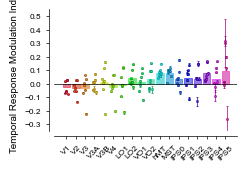

In [21]:
fig, ax = plt.subplots(figsize=cm_to_inch(6, 4))
sns.barplot(data=df_group_rois_param[df_group_rois_param.param=="TRMI"], 
            x="ROIs", 
            y="values", 
            errorbar=None, 
            hue="ROIs",
            palette=gist_rainbow_sampled,
            ax=ax,
            )

# change bar edge color
for i, bar in enumerate(ax.patches):
    bar.set_edgecolor(gist_rainbow_sampled_2[i])
    bar.set_linewidth(bar_linewidth)
    bar.set_alpha(bar_alpha)

for iroi, roi in enumerate(ROIs_list):
    for isubject, subject in enumerate(subjects):
        pos = ROIs_list.index(roi) + (norm_subID[isubject]-0.5)*0.4
        mean_data = df_group_rois_param[(df_group_rois_param.param=="TRMI") & (df_group_rois_param.ROIs==roi) & (df_group_rois_param.subjects==subject)]["values"].values[0]
        sem_data = df_group_rois_param[(df_group_rois_param.param=="TRMI") & (df_group_rois_param.ROIs==roi) & (df_group_rois_param.subjects==subject)]["SEM"].values[0]
        ax.errorbar(pos, 
                    mean_data, 
                    yerr=sem_data, 
                    fmt="none", 
                    elinewidth=errorbar_linewidth,
                    ecolor=gist_rainbow_sampled_3[iroi], 
                    capsize=errorbar_capsize, 
                    capthick=errorbar_capthick,
                    # clip_on=False,
        )
        ax.plot(pos, 
                mean_data, 
                marker=marker, 
                markeredgecolor=gist_rainbow_sampled_3[iroi], 
                markerfacecolor=gist_rainbow_sampled[iroi],
                markeredgewidth=marker_edge_width,
                markersize=markersize,
                clip_on=False,
        )

sns.despine(offset=4)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Temporal Response Modulation Index") 
plt.ylim(-0.35, 0.55)
plt.yticks([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.legend([],[], frameon=False)
plt.axhline(0, color='black', linewidth=0.5)
plt.show()
if save_figs:
    ax.figure.savefig(figure_result_dir.joinpath(f"group_analysis-{glm_analysis_type}_space-fsaverage_TRMI_barplot_supplementary.pdf"), bbox_inches="tight", dpi=600)